In [82]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas_profiling

#%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
data = pd.read_csv('/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/rugged.csv', delimiter=';')
data.describe()

,isonum,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,lon,soil,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,2.300000e+02,234.000000,234.000000,225.000000,...,234.000000,234.000000,234.000000,2.340000e+02,57.000000,57.000000,57.000000,57.000000,2.010000e+02,165.000000
mean,431.461538,1.375402,0.821585,3.942355,0.393329,19.643829,5.736381e+04,17.226902,12.903197,38.165564,...,0.068376,0.068376,0.042735,6.696709e+04,7.463842,6.761982,3.570263,3.458281,1.754828e+06,32.361224
std,252.967641,1.370052,0.916172,4.006825,0.385709,23.016250,1.711326e+05,25.085770,75.096558,27.717410,...,0.252931,0.252931,0.202693,3.216307e+05,3.314207,4.296534,1.610134,1.534231,8.001854e+06,41.754401
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,-51.745000,-177.194000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,3.541000,0.032000,0.310000,0.064000,0.000000e+00,0.000000
25%,212.500000,0.376000,0.268750,1.126750,0.104250,0.819750,3.037500e+02,0.844750,-53.196000,15.820000,...,0.000000,0.000000,0.000000,0.000000e+00,4.932000,2.623000,2.642000,2.293000,3.608200e+04,0.000000
50%,429.000000,0.961500,0.576000,2.689500,0.283000,11.771000,8.252750e+03,16.111000,17.667500,34.264000,...,0.000000,0.000000,0.000000,0.000000e+00,5.712000,7.643000,3.359000,3.529000,2.396930e+05,2.200000
75%,642.750000,1.981000,1.032250,5.628500,0.581500,32.667500,4.070725e+04,38.280250,49.827000,56.646000,...,0.000000,0.000000,0.000000,0.000000e+00,10.108000,9.457000,4.846000,4.571000,9.815910e+05,80.600000
max,894.000000,7.811000,6.722000,21.453000,2.106000,100.000000,1.638134e+06,78.845000,178.052000,100.000000,...,1.000000,1.000000,1.000000,3.610000e+06,16.393000,16.775000,6.637000,6.465000,8.094376e+07,100.000000


In [3]:
data['loggdp'] = np.log(data['rgdppc_2000'])
data.dropna(subset=['loggdp'], inplace=True)
data['rugged_std'] = data['rugged'] / data['rugged'].max()
data['loggdp'] = data['loggdp'] / data['loggdp'].mean()

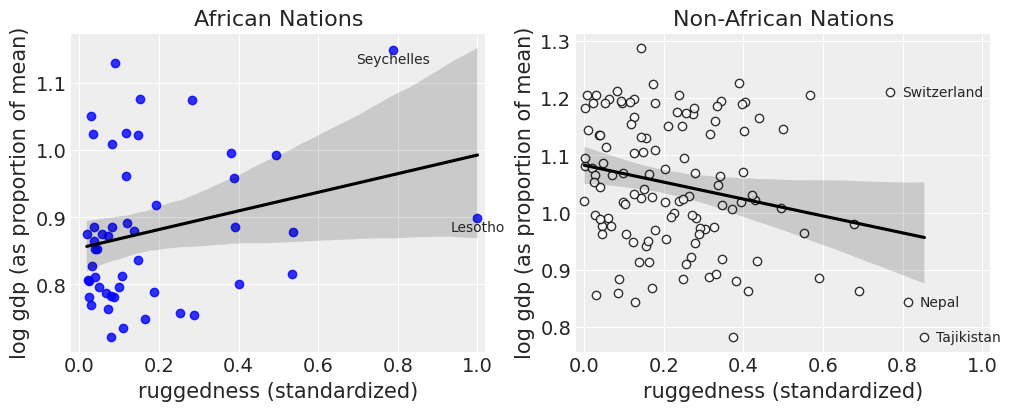

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.regplot(
    x=data.loc[data['cont_africa'] == 1]['rugged_std'], 
    y=data.loc[data['cont_africa'] == 1]['loggdp'],
    scatter_kws={'color': 'b'},
    line_kws={'color': 'k'}, 
    ax=ax[0]
)
ax[0].set_xlabel("ruggedness (standardized)")
ax[0].set_ylabel("log gdp (as proportion of mean)")
ax[0].set_title("African Nations")
for _, africa in data.loc[(data['cont_africa'] == 1) & (data['rugged_std'] > 0.7)].iterrows():
    ax[0].text(africa['rugged_std'], africa['loggdp']-0.02, africa['country'], ha='center')

sns.regplot(
    x=data.loc[data['cont_africa'] == 0]['rugged_std'], 
    y=data.loc[data['cont_africa'] == 0]['loggdp'],
    scatter_kws={'edgecolor': 'k', 'facecolor': 'w'},
    line_kws={'color': 'k'}, 
    ax=ax[1]
)
for _, nonafrica in data.loc[(data['cont_africa'] == 0) & (data['rugged_std'] > 0.7)].iterrows():
    ax[1].text(nonafrica['rugged_std']+0.03, nonafrica['loggdp'], nonafrica['country'], va='center')

ax[1].set_xlabel("ruggedness (standardized)")
ax[1].set_ylabel("log gdp (as proportion of mean)")
ax[1].set_title("Non-African Nations")

for ax_ in ax:
    ax_.set_xlim(-0.02, 1.02)

In [5]:
data[['rugged_std', 'loggdp']].describe()

,rugged_std,loggdp
count,170.000000,170.000000
mean,0.214960,1.000000
std,0.188402,0.136959
min,0.000484,0.721556
25%,0.071308,0.885214
50%,0.157933,1.007176
75%,0.315584,1.113081
max,1.000000,1.287361


In [6]:
with pm.Model() as m8_1:
    intercept = pm.Normal('intercept', 1, 0.1)
    b = pm.Normal('b', 0, 0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = intercept + b*(data['rugged_std'] - 0.215)
    log_gdp_std = pm.Normal('log_gdp_std', mu, sigma, observed=data['loggdp'])
    prior8_1 = pm.sample_prior_predictive()
    trace8_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Text(0, 0.5, 'Loggdp')

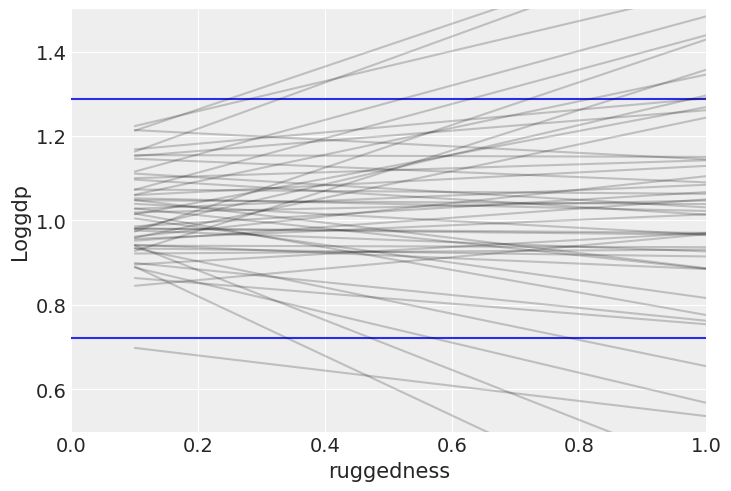

In [7]:
rugged_seq = np.linspace(0.1, 1.1, 30)
loggdp_seq = prior8_1['intercept'][:50] + prior8_1['b'][:50]*rugged_seq.reshape(-1,1)
plt.axhline(data['loggdp'].min())
plt.axhline(data['loggdp'].max())
for i in range(50):
    plt.plot(rugged_seq, loggdp_seq[:, i], color='k', alpha=0.2)
plt.xlim(0, 1)
plt.ylim(0.5, 1.5)
plt.xlabel('ruggedness')
plt.ylabel('Loggdp')

In [8]:
az.summary(trace8_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.000,0.011,0.981,1.020,0.000,0.000,4867.0,2915.0,1.0
b,0.001,0.056,-0.103,0.108,0.001,0.001,5719.0,2966.0,1.0
sigma,0.139,0.008,0.125,0.153,0.000,0.000,4918.0,2868.0,1.0


In [23]:
cid = pd.Categorical(data['cont_africa'])
with pm.Model() as m8_2:
    intercept = pm.Normal('intercept', 1, 0.1, shape=cid.categories.size)
    b = pm.Normal('b', 0, 0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = intercept[cid] + b*(data['rugged_std'] - 0.215)
    log_gdp_std = pm.Normal('log_gdp_std', mu, sigma, observed=data['loggdp'])
    trace8_2 = pm.sample()
    post8_2 = pm.sample_posterior_predictive(trace8_2, var_names=['intercept', 'b', 'sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [24]:
az.compare({'m8_1': trace8_1, 'm8_2': trace8_2}, ic='waic', scale='deviance')

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m8_2,0,-252.238490,4.154975,0.000000,0.969683,14.817481,0.000000,True,deviance
m8_1,1,-188.735134,2.620948,63.503356,0.030317,12.916435,14.631829,False,deviance


In [25]:
az.summary(trace8_2, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
intercept[0],1.05,0.01,1.03,1.07
intercept[1],0.88,0.02,0.85,0.91
b,-0.05,0.05,-0.14,0.03
sigma,0.11,0.01,0.10,0.13


In [27]:
diff8_2 = post8_2['intercept'][:,1] - post8_2['intercept'][:,0]
az.hdi(diff8_2, hdi_prob=0.89)

array([-0.1973803, -0.1350075])

Text(0, 0.5, 'Log(GDP)')

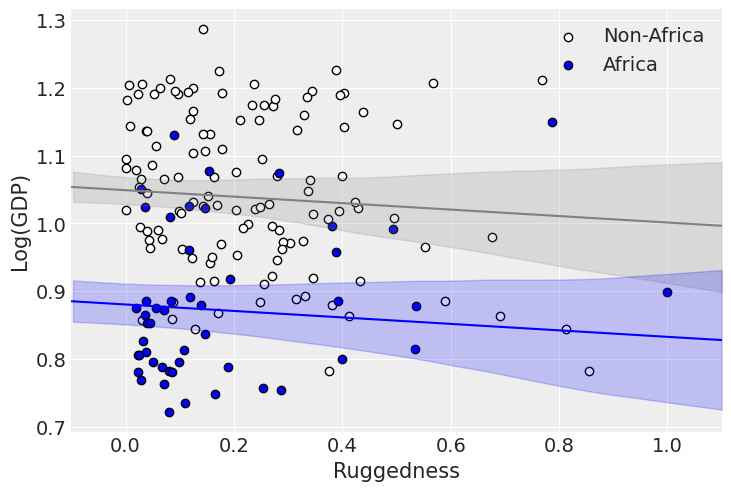

In [50]:
fig, ax = plt.subplots()
rugged_seq = np.linspace(-0.1, 1.1, 30)
ax.scatter(
    data.loc[cid == 0, 'rugged_std'],
    data.loc[cid == 0, 'loggdp'],
    facecolor='w',
    edgecolor='k',
    label='Non-Africa'
)
ax.scatter(
    data.loc[cid == 1, 'rugged_std'],
    data.loc[cid == 1, 'loggdp'],
    facecolor='b',
    edgecolor='k',
    label='Africa'
)
rugged_gdp0 = trace8_2['intercept'][:, 0] + trace8_2['b']*rugged_seq.reshape(-1, 1)
rugged_gdp1 = trace8_2['intercept'][:, 1] + trace8_2['b']*rugged_seq.reshape(-1, 1)
ax.plot(rugged_seq, rugged_gdp0.mean(axis=1), color='grey')
az.plot_hdi(rugged_seq, rugged_gdp0.T, color='grey', ax=ax, fill_kwargs={'alpha': 0.2})
ax.plot(rugged_seq, rugged_gdp1.mean(axis=1), color='b')
az.plot_hdi(rugged_seq, rugged_gdp1.T, color='b', ax=ax, fill_kwargs={'alpha': 0.2})
ax.legend()
ax.set_xlim(-0.1, 1.1)
ax.set_xlabel('Ruggedness')
ax.set_ylabel('Log(GDP)')

In [59]:
with pm.Model() as m8_3:
    intercept = pm.Normal('intercept', 1, 0.1, shape=cid.categories.size)
    b = pm.Normal('b', 0, 0.3, shape=cid.categories.size)
    sigma = pm.Exponential('sigma', 1)
    mu = intercept[cid] + b[cid]*(data['rugged_std'] - 0.215)
    log_gdp_std = pm.Normal('log_gdp_std', mu, sigma, observed=data['loggdp'])
    trace8_3 = pm.sample()
    post8_3 = pm.sample_posterior_predictive(trace8_2, var_names=['intercept', 'b', 'sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [58]:
az.compare({'m8_1': trace8_1, 'm8_2': trace8_2, 'm8_3': trace8_3}, ic='loo', scale='deviance')

/home/telescreen/Softwares/miniconda3/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m8_3,0,-259.062816,5.066817,0.000000,8.673066e-01,14.654322,0.000000,False,deviance
m8_2,1,-252.230141,4.159150,6.832675,1.326934e-01,14.818489,6.431106,False,deviance
m8_1,2,-188.722331,2.627350,70.340486,4.440892e-16,12.917436,14.930044,False,deviance


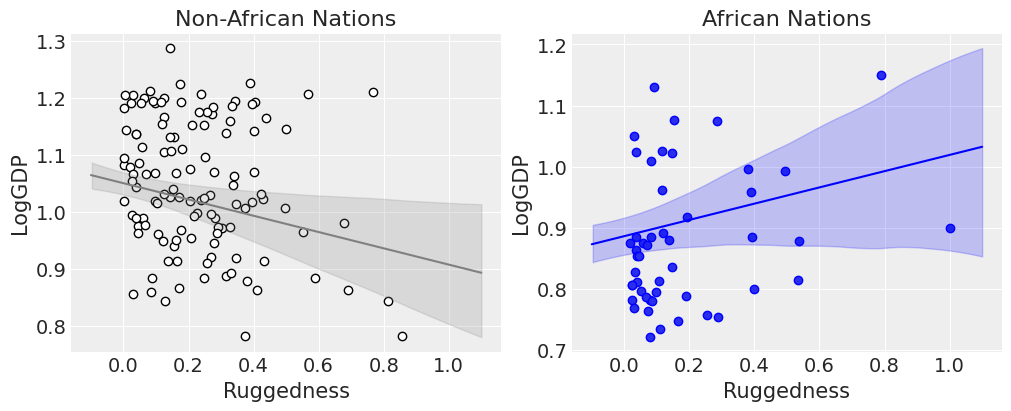

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
rugged_seq = np.linspace(-0.1, 1.1, 30)

ax[0].scatter(
    data.loc[cid == 0, 'rugged_std'],
    data.loc[cid == 0, 'loggdp'],
    facecolor='w',
    edgecolor='k',
    label='Non-Africa'
)
rugged_gdp0 = trace8_3['intercept'][:, 0] + trace8_3['b'][:, 0]*rugged_seq.reshape(-1, 1)
ax[0].plot(rugged_seq, rugged_gdp0.mean(axis=1), color='grey')
az.plot_hdi(rugged_seq, rugged_gdp0.T, color='grey', ax=ax[0], fill_kwargs={'alpha': 0.2})
ax[0].set_title('Non-African Nations')

ax[1].scatter(
    data.loc[cid == 1, 'rugged_std'],
    data.loc[cid == 1, 'loggdp'],
    facecolor='C0',
    edgecolor='b',
    label='Africa'
)
rugged_gdp1 = trace8_3['intercept'][:, 1] + trace8_3['b'][:, 1]*rugged_seq.reshape(-1, 1)
ax[1].plot(rugged_seq, rugged_gdp1.mean(axis=1), color='b')
az.plot_hdi(rugged_seq, rugged_gdp1.T, color='b', ax=ax[1], fill_kwargs={'alpha': 0.2})
ax[1].set_title('African Nations')

for axes in ax:
    axes.set_xlabel('Ruggedness')
    axes.set_ylabel('LogGDP')

Text(0, 0.5, 'Expected Difference of LogGDP')

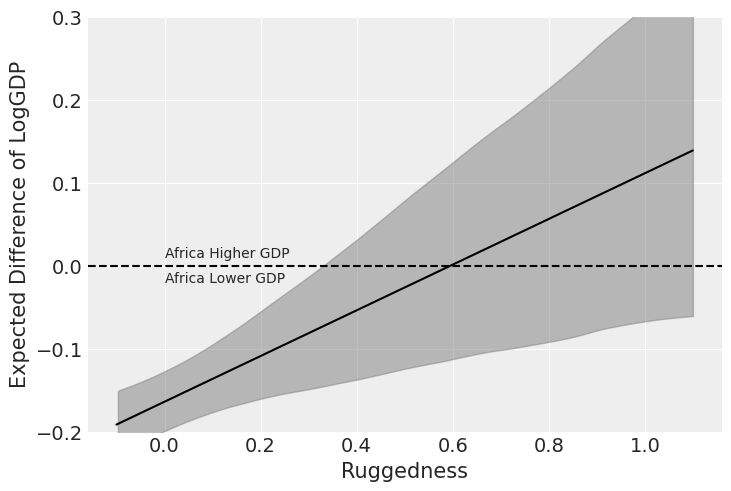

In [77]:
loggdp_diff = rugged_gdp1 - rugged_gdp0
plt.plot(rugged_seq, loggdp_diff.mean(1), color='k')
plt.ylim(-0.2, 0.3)
az.plot_hdi(rugged_seq, loggdp_diff.T, ax=plt.gca(), color='grey')
plt.axhline(0, ls='dashed', color='k')
plt.text(0, 0.01, 'Africa Higher GDP')
plt.text(0, -0.02, 'Africa Lower GDP')
plt.xlabel('Ruggedness')
plt.ylabel('Expected Difference of LogGDP')

In [88]:
tulips = pd.read_csv('/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/tulips.csv', delimiter=';')
tulips.describe()

,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


In [89]:
tulips['blooms_std'] = tulips['blooms'] / tulips['blooms'].max()
tulips['water_cent'] = tulips['water'] - tulips['water'].mean()
tulips['shade_cent'] = tulips['shade'] - tulips['shade'].mean()

In [90]:
tulips.describe()

,water,shade,blooms,blooms_std,water_cent,shade_cent
count,27.00000,27.00000,27.000000,27.000000,27.00000,27.00000
mean,2.00000,2.00000,128.993704,0.356671,0.00000,0.00000
std,0.83205,0.83205,92.683923,0.256274,0.83205,0.83205
min,1.00000,1.00000,0.000000,0.000000,-1.00000,-1.00000
25%,1.00000,1.00000,71.115000,0.196635,-1.00000,-1.00000
50%,2.00000,2.00000,111.040000,0.307029,0.00000,0.00000
75%,3.00000,3.00000,190.300000,0.526185,1.00000,1.00000
max,3.00000,3.00000,361.660000,1.000000,1.00000,1.00000


In [95]:
stats.norm.cdf(0) + 1 - stats.norm.cdf(1)

0.6586552539314571

In [97]:
stats.norm.cdf(0, loc=0.5, scale=0.25) + 1 - stats.norm.cdf(1, loc=0.5, scale=0.25)

0.045500263896358306